In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 482 kB 5.4 MB/s 
     |████████████████████████████████| 41 kB 566 kB/s 


Importing all the necessary libraries

In [ ]:
from torch_geometric.datasets import QM9
import torch
# from torch.nn import MSE
from torch.optim import Adam
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GAE, GCNConv
from torch_geometric.utils import to_dense_adj
from torch_geometric.transforms import NormalizeFeatures
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

Graph Autoencoder

In [ ]:
# define the encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# define the GAE model
def build_model(encoder_in, encoder_out):
    # should use the default decoder provided by pytorch geometric - innerproduct decoder
    model = GAE(GCNEncoder(encoder_in, encoder_out), None)
    return model

Loading the QM9 dataset 

In [ ]:
# loading the QM9 dataset
dataset = QM9(root="tmp/QM9", transform=NormalizeFeatures())

# shuffle the dataset
torch.manual_seed(123)
dataset = dataset.shuffle()

# 130,831 graphs are in the QM9 dataset, but we'll use 3000
num_of_graphs = 6000
train_idx = math.floor(0.80 * num_of_graphs)

Extracting tmp/QM9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Splitting into training and testing datasets

In [ ]:
train_dataset = dataset[:train_idx]
test_dataset = dataset[train_idx:num_of_graphs]

In [ ]:
batch_size = 32

# training and testing loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

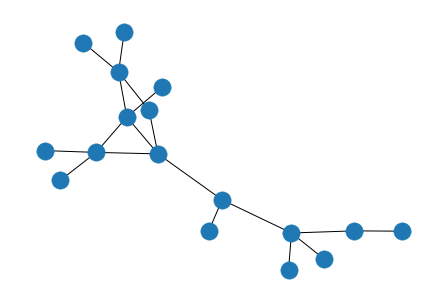

In [ ]:
g = to_networkx(train_dataset[9], to_undirected=True)
nx.draw(g)

In [ ]:
# defining some variables for training the model
num_features = dataset.num_features
output_nodes = 11
epochs = 100

In [ ]:
# define the graph autoencoder
model = build_model(num_features, output_nodes)

# defining the optimizer and the loss function
optimizer = Adam(model.parameters(), lr=0.001)
# criterion = MSELoss()

# GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Training and Testing 

In [ ]:
# training the model

def train():
    model.train()

    for data in train_loader:
        # speed up the computation
        train_x = data.x.to(device)
        train_edge_index = data.edge_index.to(device)
        z = model.encode(train_x, train_edge_index)
        loss = model.recon_loss(z, train_edge_index)
        # back propagation
        loss.backward()
        optimizer.step()
        # clear gradients
        optimizer.zero_grad()

In [ ]:
# testing the model, very similar to train, but the gradients don't update

def test(loader):
    model.eval()

    loss_history = []
    for data in loader:
        with torch.no_grad():
            x = data.x.to(device)
            edge_index = data.edge_index.to(device)
            z = model.encode(x, edge_index)
            loss = model.recon_loss(z, edge_index)
            loss_history.append(loss)
    return np.sum(loss_history) / len(loader.dataset)

In [ ]:
train_loss_history = []
test_loss_history = []

# iterating over the epochs
for epoch in range(1, epochs+1):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)

    # store the train and test reconstruction loss so we can visualize later
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print(f'Epoch: {epoch:03d}, Train Recon Loss: {train_loss:.4f}, Test Recon Loss: {test_loss:.4f}')

Epoch: 001, Train Recon Loss: 0.0342, Test Recon Loss: 0.0346
Epoch: 002, Train Recon Loss: 0.0342, Test Recon Loss: 0.0346
Epoch: 003, Train Recon Loss: 0.0342, Test Recon Loss: 0.0345
Epoch: 004, Train Recon Loss: 0.0341, Test Recon Loss: 0.0346
Epoch: 005, Train Recon Loss: 0.0340, Test Recon Loss: 0.0346
Epoch: 006, Train Recon Loss: 0.0340, Test Recon Loss: 0.0343
Epoch: 007, Train Recon Loss: 0.0340, Test Recon Loss: 0.0344
Epoch: 008, Train Recon Loss: 0.0339, Test Recon Loss: 0.0343
Epoch: 009, Train Recon Loss: 0.0339, Test Recon Loss: 0.0343
Epoch: 010, Train Recon Loss: 0.0339, Test Recon Loss: 0.0342
Epoch: 011, Train Recon Loss: 0.0339, Test Recon Loss: 0.0343
Epoch: 012, Train Recon Loss: 0.0338, Test Recon Loss: 0.0342
Epoch: 013, Train Recon Loss: 0.0338, Test Recon Loss: 0.0342
Epoch: 014, Train Recon Loss: 0.0337, Test Recon Loss: 0.0341
Epoch: 015, Train Recon Loss: 0.0338, Test Recon Loss: 0.0341
Epoch: 016, Train Recon Loss: 0.0338, Test Recon Loss: 0.0342
Epoch: 0

In [ ]:
def plot_epochs_history(data, title, x_axis, y_axis):
    plt.figure(figsize=(8, 6))
    plt.plot(data)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.show()

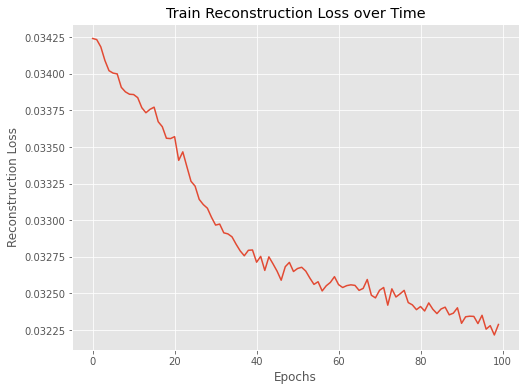

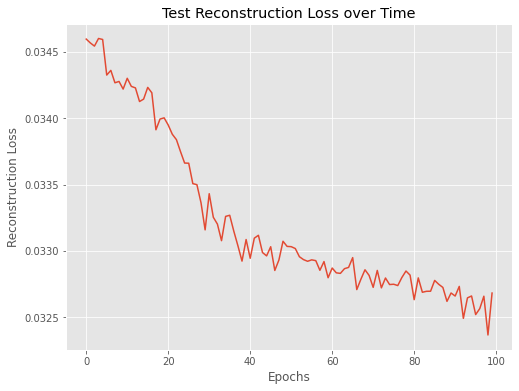

In [ ]:
# visualization!!!
plot_epochs_history(train_loss_history, "Train Reconstruction Loss over Time", "Epochs", "Reconstruction Loss")
plot_epochs_history(test_loss_history, "Test Reconstruction Loss over Time", "Epochs", "Reconstruction Loss")

Original


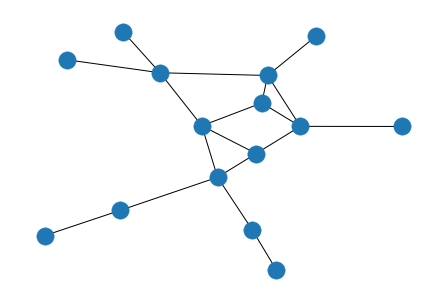

Predicted


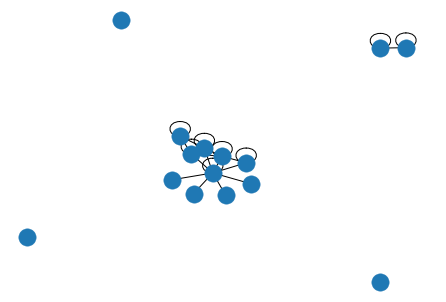

Original


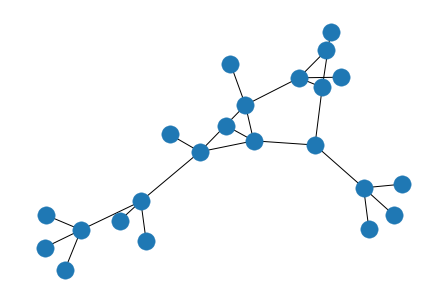

Predicted


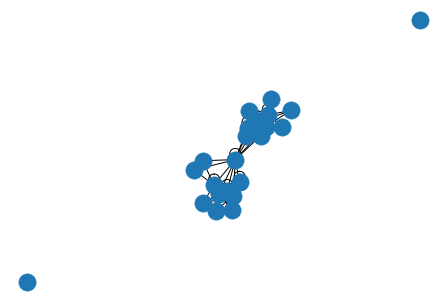

Original


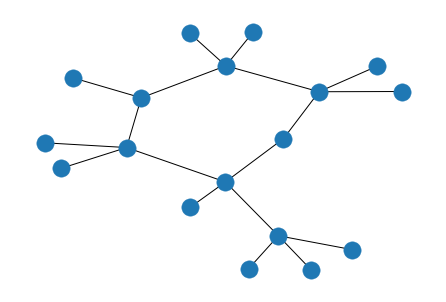

Predicted


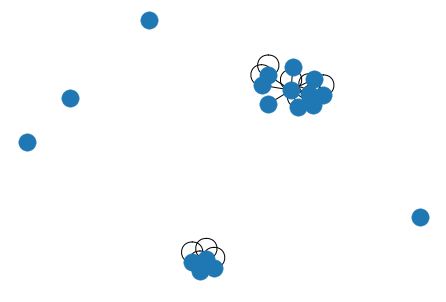

Original


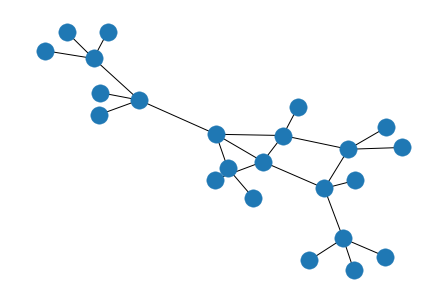

Predicted


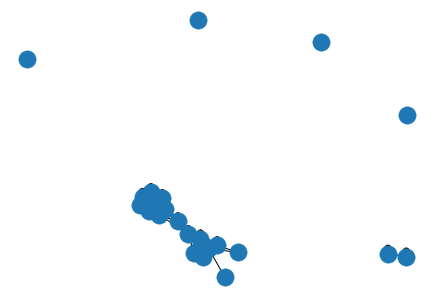

Original


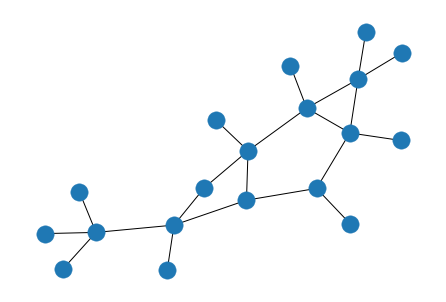

Predicted


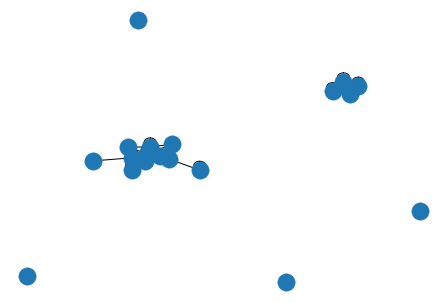

In [ ]:
model.eval()

# extracting graphs from the batched large graph 
for data in test_loader:
    with torch.no_grad():
        # original data but only with x and edge_index

        for i in range(5):
          graph = data.get_example(i)
          x = graph.x.to(device)
          edge_index = graph.edge_index.to(device)
          z = model.encode(x, edge_index)
          # prob_edges = model.decode(z, edge_index)
          
          adj = model.decoder.forward_all(z, sigmoid=True)
          o_edge_index = (adj > 0.8).nonzero(as_tuple=False).t()
          output = Data(x=z, edge_index=o_edge_index)
          print("Original")
          g = to_networkx(graph, to_undirected=True)
          nx.draw(g)
          plt.show()
          print("Predicted")
          n = to_networkx(output, to_undirected=True)
          nx.draw(n)
          plt.show()

          # z = model.encode(graph.x, graph.edge_index)
          # edge_prob = model.decode(z, graph.edge_index)
        break